In [109]:
import pandas as pb
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import chi2


Donwload data, find the entrias

In [ ]:
# read all csv, rename "no. clicks" to "clicks" in teh process and add colum, that contains the version
a_df = pb.read_csv("C:/Users/Marcus/Documents/DSAI/a_b_testing_notebooks/data/eniac_a.csv").rename(columns={"No. clicks": "clicks"}).assign(version="a")
b_df = pb.read_csv("C:/Users/Marcus/Documents/DSAI/a_b_testing_notebooks/data/eniac_b.csv").rename(columns={"No. clicks": "clicks"}).assign(version="b")
c_df = pb.read_csv("C:/Users/Marcus/Documents/DSAI/a_b_testing_notebooks/data/eniac_c.csv").rename(columns={"No. clicks": "clicks"}).assign(version="c")
d_df = pb.read_csv("C:/Users/Marcus/Documents/DSAI/a_b_testing_notebooks/data/eniac_d.csv").rename(columns={"No. clicks": "clicks"}).assign(version="d")



In [ ]:
# from the line that contains the snapschot informatan, extract the number of visists and make it a plain integer scalar
a_visits = a_df.loc[a_df["Snapshot information"].str.contains(r"\d* visits", na=False),"Snapshot information"].str.extract(r'(\d+)\s*visits', expand=False).astype(int).values[0]
b_visits = b_df.loc[b_df["Snapshot information"].str.contains(r"\d* visits", na=False),"Snapshot information"].str.extract(r'(\d+)\s*visits', expand=False).astype(int).values[0]
c_visits = c_df.loc[c_df["Snapshot information"].str.contains(r"\d* visits", na=False),"Snapshot information"].str.extract(r'(\d+)\s*visits', expand=False).astype(int).values[0]
d_visits = d_df.loc[d_df["Snapshot information"].str.contains(r"\d* visits", na=False),"Snapshot information"].str.extract(r'(\d+)\s*visits', expand=False).astype(int).values[0]



np.int64(25326)

In [118]:
#add visists a a column, calculate 'no_clicks' from it.
data_df = pb.concat([a_df.assign(visits=a_visits), b_df.assign(visits=b_visits), c_df.assign(visits=c_visits), d_df.assign(visits=d_visits)]).query("Name == 'SHOP NOW' or Name == 'SEE DEALS'").set_index("version")
data_df["no_clicks"] = data_df["visits"] - data_df["clicks"]

#CTS
print("CTS")
print((data_df["clicks"] / data_df["visits"]).sort_values(ascending=False))

# make rows to colums, so it'll fid for the chi-squared Test
observed = data_df[["clicks", "no_clicks" ]].T
print(observed)

CTS
version
c    0.021185
a    0.020216
b    0.011355
d    0.007649
dtype: float64
version        a      b      c      d
clicks       512    281    527    193
no_clicks  24814  24466  24349  25040


In [104]:
alpha = 0.05
chisq, pvalue, df, expected = chi2_contingency(observed)
print(chisq, pvalue, df)
expected



224.01877488058412 2.7161216607868712e-48 3


array([[  382.48625502,   373.74189974,   375.69012397,   381.08172127],
       [24943.51374498, 24373.25810026, 24500.30987603, 24851.91827873]])

In [106]:
if pvalue > alpha:
    print("The p-value is grater than alpha, the null hypothesis cannot be rejected!")
else:
    print("The p-value is smaller than alpha, we reject the null hypothesis.")

The p-value is smaller than alpha, we reject the null hypothesis.


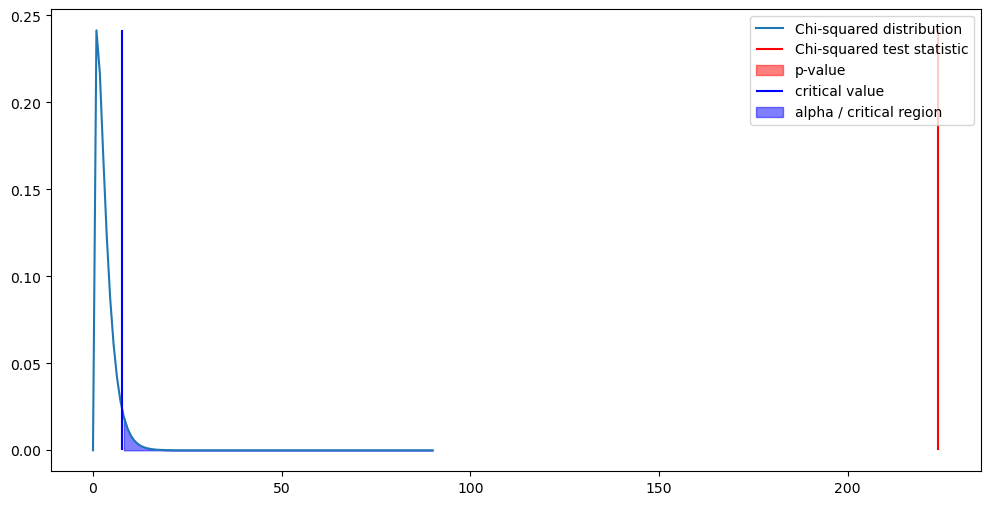

In [115]:
critical_value = 7.815
dof = 3
xt = np.linspace(0, 90, 100)


# @title Chi-squared distribution, test statistic, critical value and alpha
plt.figure(figsize=(12, 6))
# Plot a chi-squared distribution with the degrees of freedom from our sample.
plt.plot(xt, chi2.pdf(xt, dof), label="Chi-squared distribution")
# Add a vertical line for the chi-squared test statistic.
plt.vlines(
    chisq,
    ymin=0,
    ymax=max(chi2.pdf(xt, dof)),
    color="red",
    label="Chi-squared test statistic",
)
# Shade the region in the tails that is more extreme than the test statistic (= p-value).
plt.fill_between(
    xt,
    chi2.pdf(xt, dof),
    where=(xt > chisq),
    color="r",
    alpha=0.5,
    label="p-value",
)
# Add vertical line for the critical value.
plt.vlines(
    critical_value,
    ymin=0,
    ymax=max(chi2.pdf(xt, dof)),
    color="blue",
    label="critical value",
)
# Shade the area under the curve for values more extreme than 4.6 (= alpha).
plt.fill_between(
    xt,
    chi2.pdf(xt, dof),
    where=(xt > critical_value),
    color="b",
    alpha=0.5,
    label="alpha / critical region",
)
plt.legend()
plt.show()

Post-hoc-tests:

# 🧩 Post-hoc Analyse des Chi-Quadrat-Tests

Nachdem der Chi-Quadrat-Test für die vier Varianten (A, B, C, D) ein hochsignifikantes
Ergebnis geliefert hat (χ² = 224.02, p ≈ 2.7e-48), wissen wir:

**👉 Die Klickrate hängt signifikant von der Version ab.**

Der Test sagt jedoch nicht, *welche* Versionen sich unterscheiden.  
Daher führen wir **Post-hoc Chi-Quadrat-Tests** für alle Paarvergleiche durch.

---

## 🔢 Bonferroni-Korrektur

Es gibt 6 paarweise Vergleiche:

- A vs B  
- A vs C  
- A vs D  
- B vs C  
- B vs D  
- C vs D  

Die korrigierte Signifikanzgrenze lautet:

\[
\alpha_{\text{neu}} = \frac{0.05}{6} = 0.00833
\]

Ein Vergleich ist nur signifikant, wenn:

\[
p < 0.00833
\]

---

## 📊 Ergebnisse der Post-hoc Tests

| Vergleich | Signifikant? | Interpretation |
|----------|--------------|----------------|
| **A vs B** | ✔ | A hat höhere CTR als B |
| **A vs C** | ✘ | A und C unterscheiden sich nicht signifikant |
| **A vs D** | ✔ | A ist deutlich besser als D |
| **B vs C** | ✔ | C ist deutlich besser als B |
| **B vs D** | ✔ | B ist besser als D |
| **C vs D** | ✔ | C ist deutlich besser als D |

---

## 🧠 Interpretation

- Version **D** ist klar die schlechteste (signifikant schlechter als alle anderen).
- Version **B** ist besser als D, aber schlechter als A und C.
- Version **A** und **C** unterscheiden sich **nicht signifikant** voneinander.
- Version **C** schlägt jedoch sowohl B als auch D deutlich.

---

# 🏆 Finaler Gewinner

Unter Berücksichtigung:

- der **höchsten CTR**,  
- der **signifikanten Unterschiede** zu B und D,  
- und der Tatsache, dass C **nicht schlechter** als A ist,

ergibt sich:

## 🎉 **Version C ist der Gewinner.**

Sie zeigt die beste Gesamtperformance und ist statistisch klar überlegen.

In [119]:
data_df

,Element ID,Tag name,Name,clicks,Visible?,Snapshot information,visits,no_clicks
version,,,,,,,,
a,106,a,SHOP NOW,512,True,NaN,25326,24814
b,126,a,SHOP NOW,281,True,NaN,24747,24466
c,127,a,SEE DEALS,527,True,NaN,24876,24349
d,128,a,SEE DEALS,193,True,NaN,25233,25040
